# Отчет

- Все пункты плана были выполнены. Единственно в начале было предположение поиска тренда и сезонности, но после разбора задачи с тимлидом выяснили, что партии друг от друга не зависят и не надо рассматривать данные как времянной ряд.
- Были трудности по пониманию тех.процесса, но их обошли путем обсуждения задачи с тимлидом и поиском информации в интернете.
- Ключевые шаги: Обработка данных. Выделение полезных признаков и создание новых из имеющихся. Выбор модели.
- Итоговая модель: CatBoost, значение МАЕ: 5.2

### Цель работы
Оптимизация производственных расходов, металлургического комбината ООО «N» путем уменьшиения потребления электроэнергии на этапе обработки стали. Бизнес-метрика рассход электроэнергии, метрика модели: MAE.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы

- Анализ данных
- Обработка данных
- Подготовка и изучение признаков
- Выбор модели
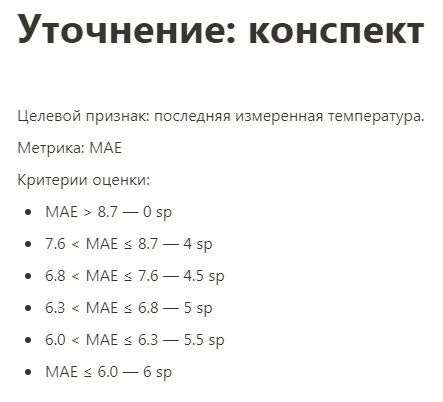

# 1 Анализ данных

In [1]:
from IPython.display import display
from IPython.core.display import HTML

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool, cv

df_arc = pd.read_csv('datasets/data_arc.csv')
df_bulk = pd.read_csv('datasets/data_bulk.csv')
df_bulk_time = pd.read_csv('datasets/data_bulk_time.csv')
df_gas = pd.read_csv('datasets/data_gas.csv')
df_temp = pd.read_csv('datasets/data_temp.csv')
df_wire = pd.read_csv('datasets/data_wire.csv')
df_wire_time = pd.read_csv('datasets/data_wire_time.csv')

df_list = {
    'df_arc' : df_arc,
    'df_bulk' : df_bulk,
    'df_bulk_time' : df_bulk_time,
    'df_gas' : df_gas,
    'df_wire' : df_wire,
    'df_wire_time' : df_wire_time,
    'df_temp' : df_temp
}

In [2]:
def display_df_info(df, key):
    display(HTML('<h2>'+key+'</h2>'))
    display(df.info())
    display(df.describe())
    display(df.head(10))
    display(HTML('<hr>'))

In [3]:
for key in df_list:
    display_df_info(df_list[key], key)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


## Количество данных по каждой партии

In [4]:
def display_key_counts(df, df_name):
    print(key)
    print('Всего записей в таблице:', df.shape[0])
    print('Уникальных значений key:',  df['key'].unique().shape[0])
    print('\n')

In [5]:
for key in df_list:
    display_key_counts(df_list[key], key)

df_arc
Всего записей в таблице: 14876
Уникальных значений key: 3214


df_bulk
Всего записей в таблице: 3129
Уникальных значений key: 3129


df_bulk_time
Всего записей в таблице: 3129
Уникальных значений key: 3129


df_gas
Всего записей в таблице: 3239
Уникальных значений key: 3239


df_wire
Всего записей в таблице: 3081
Уникальных значений key: 3081


df_wire_time
Всего записей в таблице: 3081
Уникальных значений key: 3081


df_temp
Всего записей в таблице: 15907
Уникальных значений key: 3216




# 1 Вывод

### df_arc
Пропусков нет, перевести `Начало нагрева дугой` и `Конец нагрева дугой` в формат времени. Есть отрициательные значения, их попробуем восстановить по следующей формуле. Активную и реактивную мощность можно пересчитать в полную мощность
$$ S = \sqrt{A^2 + Q^2} $$
, где `S` - полная мощность, `A` - активная мощность, `Q` - реактивная мощность

### df_bulk, df_bulk_time 
Данные преобразовать в формат времени (Таблица `df_bulk_time`). В `df_bulk_time` некоторые значения совпадают. Пропуски заменим нулями, очевидно, что были записаны только значения отличные от нуля

### df_gas 
Данные в порядке

### df_temp 
Пропуски есть. 1й столбец преобразовать данные в формат времени. 2й столб - содержит целевой признак. Пропуски удалим.

### df_wire , df_wire_time 
Заметно, что первые две "проволки" содержат большего всего значений. Возможно стоит все объединить как в `df_bulk, df_bulk_time `


#  2 Обработка данных

### Переименуем столбцы

In [6]:
# названия столбцов приводим в латиницу и т.д.
df_arc.columns = ['key', 'start_time', 'finish_time', 'active_p', 'reactive_p']
df_gas.columns = ['key', 'gas']
df_temp.columns = ['key', 'measure_time', 'temp']
for key in df_list:
    df_list[key].columns = [col.lower().replace(' ', '_') for col in df_list[key].columns]

### Преобразование типов данных "время"

In [7]:
for key in df_list:
    if 'time' in key: # Если в названии фрейма есть time, значит все столбцы содержат время
        for col in df_list[key].columns:
            if col == 'key': continue
            df_list[key][col] = pd.to_datetime(df_list[key][col], format='%Y-%m-%d %H:%M:%S', errors='ignore')
    else: # Ищем столбцы, которые содержат в названии time
        for col in df_list[key].columns:
            if col == 'key' or col.find('time') == -1: continue
            df_list[key][col] = pd.to_datetime(df_list[key][col], format='%Y-%m-%d %H:%M:%S', errors='ignore')
    display(df_list[key].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          14876 non-null  int64         
 1   start_time   14876 non-null  datetime64[ns]
 2   finish_time  14876 non-null  datetime64[ns]
 3   active_p     14876 non-null  float64       
 4   reactive_p   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   measure_time  15907 non-null  datetime64[ns]
 2   temp          13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None

<hr>

### Обработка отрицательных значений в мощности

In [8]:
df_arc[df_arc['reactive_p'] < 0]

,key,start_time,finish_time,active_p,reactive_p
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [9]:
df_arc[df_arc['key']==2116]

,key,start_time,finish_time,active_p,reactive_p
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Восстановим значение используя формулу полной мощности, коэффициента мощности и значений предыдущих строк

In [10]:
def get_power(P, Q):
    """
    P - активная мощность
    Q - реактивная мощность
    ----
    S - полная мощность
    cos - коэффициент мощности
    """
    S = ((P**2) + (Q**2))**(1/2)
    cos = P / S
    return cos, S

In [11]:
df_arc_2116 = df_arc[df_arc['key']==2116]
list_cos = np.array([])
for P, Q in zip(df_arc_2116['active_p'], df_arc_2116['reactive_p']):
    if Q < 0: continue
    cos, S = get_power(P, Q)
    list_cos = np.append(list_cos, cos)
    print('Коэффициент: ', cos, 'Полная мощность: ', S)

cos_mean = np.mean(list_cos)
print('Среднее значение коэффициента', cos_mean)

Коэффициент:  0.8166961862011811 Полная мощность:  0.5305110194224308
Коэффициент:  0.8352421725288331 Полная мощность:  0.742616358225839
Коэффициент:  0.8330541578646709 Полная мощность:  0.35936144628022143
Среднее значение коэффициента 0.8283308388648951


Теперь восстановим значение:

In [12]:
P = 0.495782 
S = P / cos_mean
Q = ((S**2) - (P**2))**(1/2)
Q

0.3353207735910155

In [13]:
df_arc.iloc[9780, df_arc.columns.get_loc('reactive_p')] = Q
df_arc[df_arc['key']==2116]

,key,start_time,finish_time,active_p,reactive_p
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,0.335321
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


### Таблицы bulk и wire

Пропуски в сыпучих материалах и проволке заполним нулями

In [14]:
df_bulk = df_bulk.fillna(0)
df_wire = df_wire.fillna(0)
df_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<hr>

### Поиск аномалий

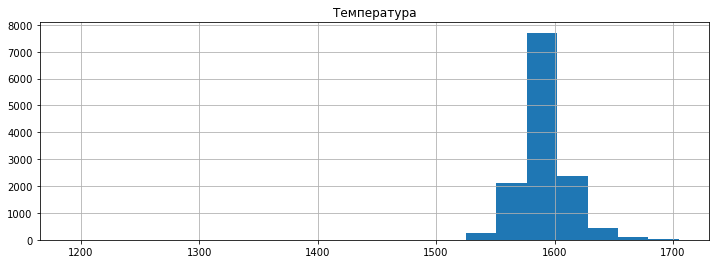

In [15]:
plt.title('Температура')
df_temp['temp'].hist(bins=20, figsize=(12, 4))

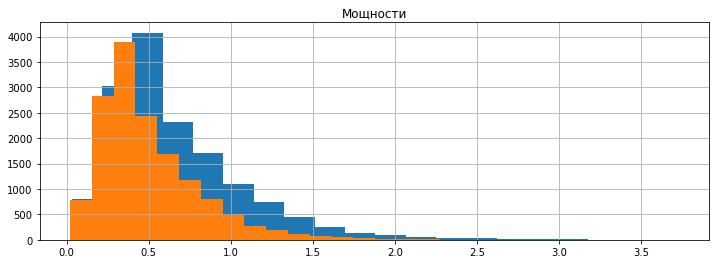

In [16]:
plt.title('Мощности')
df_arc['active_p'].hist(bins=20, figsize=(12, 4))
df_arc['reactive_p'].hist(bins=20, figsize=(12, 4))

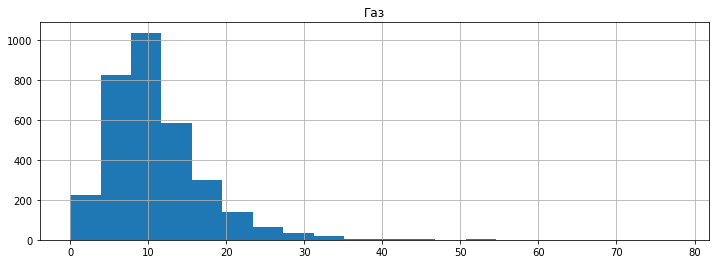

In [17]:
plt.title('Газ')
df_gas['gas'].hist(bins=20, figsize=(12, 4))

## 2 Вывод
Типы данных преобразованы. Столбцы переименованы. Некоторые значения восстановлены. Пропуски в `df_bulk` и `df_wire` заполнены. Данные распределены в целом нормально, есть небольшие смещения.

# 3 Подготовка признаков

Взглянем как распределены процессы во времени

In [18]:
def display_key_scatter(df, df_name, count, num, legend_list):
    """
    df - датафрейм
    df_name - название датафрейма
    count - порядковый номер датафрейма
    num - номер партии
    ------
    строим график, где ось Х - это время процесса, ось Y заполним номером процесса, т.е. count
    """
    df = df[df['key']==num] # Отбираем нужную партию 
    if 'time' in df_name: # Если в названии фрейма есть time, значит все столбцы содержат время
        index = df.index
        for col in df.columns:
            if col == 'key': continue
            try:            
                if pd.notnull(df.iloc[0][col]):
                    plt.scatter(
                        df[col], 
                        [count for _ in range(len(df))]
                    )
                    legend_list.append(str(num) + ' ' + df_name+': '+col)  
            except:
                print(df_name, col, df[col])

    else: # Ищем столбцы, которые содержат в названии time
        for col in df.columns:
            if col == 'key' or 'time' not in col: continue
            legend_list.append(str(num) + ' ' + df_name+': '+col)
            plt.scatter(
                df[col], 
                [count for _ in range(len(df))]
            )

### Посмотрим на некоторые партии по отдельности

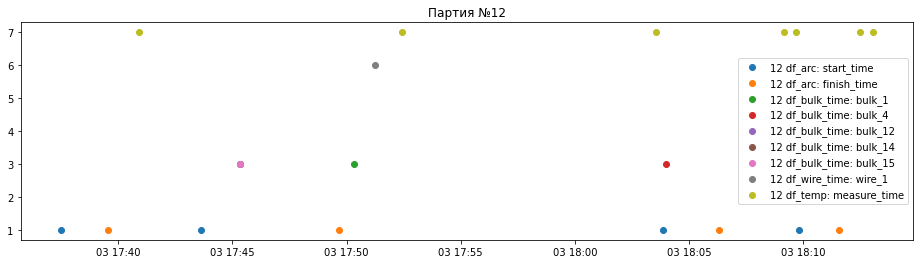

In [19]:
legend_list = []
num = 1
part= 12
plt.figure(figsize=(16,4))
for key in df_list:
    display_key_scatter(df_list[key], key, num, part, legend_list)
    num += 1
plt.legend(legend_list)
_ = plt.title('Партия №'+ str(part))

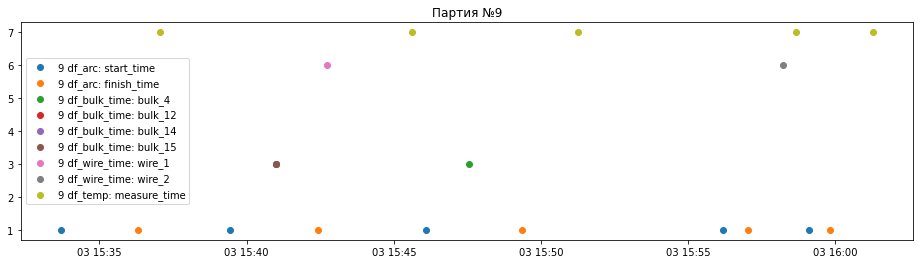

In [20]:
legend_list = []
num = 1
part= 9
plt.figure(figsize=(16,4))
for key in df_list:
    display_key_scatter(df_list[key], key, num, part, legend_list)
    num += 1
plt.legend(legend_list)
_ = plt.title('Партия №'+ str(part))

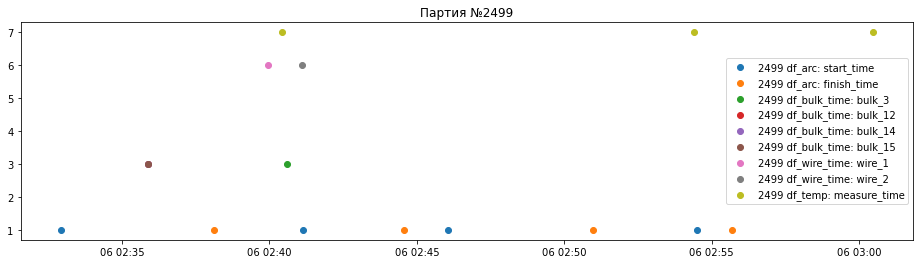

In [21]:
legend_list = []
num = 1
part= 2499
plt.figure(figsize=(16,4))
for key in df_list:
    display_key_scatter(df_list[key], key, num, part, legend_list)
    num += 1
plt.legend(legend_list)
_ = plt.title('Партия №'+ str(part))

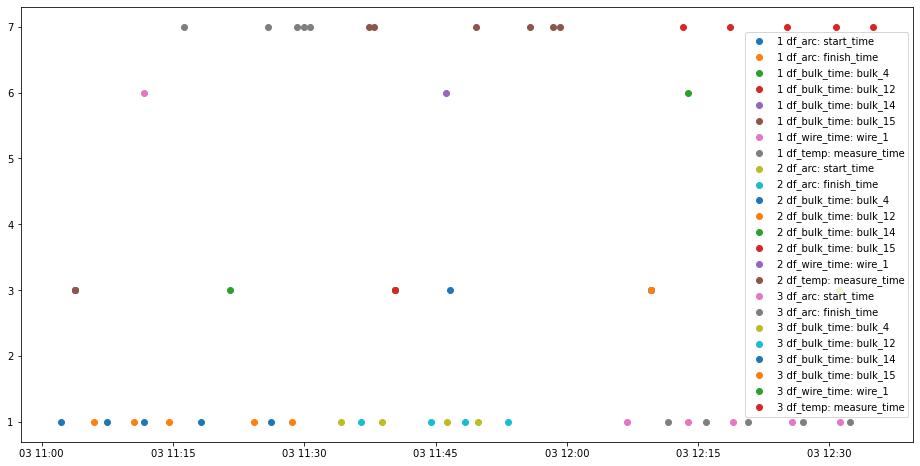

In [22]:
legend_list = []

part= 150
part_ = part + 1
plt.figure(figsize=(16,8))
for p in range(1, 4):
    num = 1
    for key in df_list:
        display_key_scatter(df_list[key], key, num, p, legend_list)
        num += 1
        
plt.legend(legend_list)

Партии идут друг за другом. Причем добавление проволочных и сыпучих материалов может происходить и до, и после первого измерения температуры

<hr>

### Выделим уникальные партии
Найдем пересечение всех партий, т.е. те партии которые присутствуют во всех таблицах, кроме `df_bulk` и `df_wire` - при отсутствии ключа в этих таблицах, заполним значения нулями

In [23]:
key_list_temp = df_temp['key'].unique()
key_list_arc = df_arc['key'].unique()
key_list_gas = df_gas['key'].unique()

all_keys = np.intersect1d(key_list_temp, key_list_arc)
all_keys = np.intersect1d(all_keys, key_list_gas)
len(all_keys)

3212

### Выбор признаков
Разделем признаки нагрева электродом на До первого измерения и между первым и последним измерением. Зная время и мощность получим совершенную работу. Также выделим интервал между измерениями температуры

In [24]:
df_col = {
    'key':[], # номер партии
    'before_work':[], # работа до первого измерения температуры
    'after_work':[], # работа после первого измерения и до последнего температуры
    'before_duration_power':[], # длительность нагрева до первого измерения температуры
    'after_duration_power':[], # длительность нагрева после первого измерения и до последнего температуры
    'gas':[], # значение продува газом
    'temp_before':[], # первое измерение температуры
    'temp_after':[], # последнее измерение температуры
    'measure_interval':[], # время между измерениями
    'before_power':[], # мощность до первого измерения
    'after_power':[], # мощность после первого измерения
    'cos':[] # коэф. мощности нагрева
}

# добавление столбцов df_bulk и df_wire
for col in np.concatenate((df_bulk.columns, df_wire.columns)):
    df_col[col] = []

df_res = pd.DataFrame(df_col)
df_res

,key,before_work,after_work,before_duration_power,after_duration_power,gas,temp_before,temp_after,measure_interval,before_power,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9


Посчитаем полную мощность, длительности и работу электродов

In [25]:
def get_pow_dur_work(row):
    cos, full_power = get_power(row['active_p'], row['reactive_p']) # нужна только полная мощность
    duration = (row['finish_time'] - row['start_time']).total_seconds()
    work = duration * full_power
    return full_power, duration, work, cos
df_arc['power'], df_arc['duration'], df_arc['work'], df_arc['cos'] = zip(*df_arc.apply(get_pow_dur_work, axis=1))
df_arc.head()

,key,start_time,finish_time,active_p,reactive_p,power,duration,work,cos
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0,272.149755,0.817717
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0,177.416785,0.840041
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0,154.118502,0.830728
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0,719.221394,0.842115
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0,119.471318,0.858178


Разделем признаки нагрева электродом на До первого измерения и между первым и последним измерением. Зная время и мощность получим совершенную работу

In [26]:
def get_features(key):
    """
    Фильтруем таблицы по номеру партии - key
    Получаем первое и последнее времена измерения температуры
    Разделяем таблице нагрева электродами на до и после первого измерения температуры
    Получаем значения
    """
    df_temp_k = df_temp[df_temp['key'] == key]
    len_meas = len(df_temp_k)
    last_pos = len_meas - 1
    first_measure = df_temp_k.iloc[0]['measure_time']
    last_measure = df_temp_k.iloc[last_pos]['measure_time']
    df_arc_before = df_arc[
        (first_measure > df_arc['start_time']) & 
        (df_arc['key'] == key)
    ]    
    df_arc_after = df_arc[
        (first_measure < df_arc['start_time']) &
        (last_measure > df_arc['start_time']) & 
        (df_arc['key'] == key)
    ]    
    cos_before = df_arc_after['cos'].mean()
    cos_after = df_arc_after['cos'].mean()
    cos = (cos_before + cos_after)/2
    before_work = df_arc_before['work'].sum()
    after_work = df_arc_after['work'].sum()
    before_power = df_arc_before['power'].mean()
    after_power = df_arc_after['power'].mean()
    before_duration_power = df_arc_before['duration'].sum()
    after_duration_power = df_arc_after['duration'].sum()
    temp_before = df_temp_k.iloc[0]['temp']
    temp_after = df_temp_k.iloc[last_pos]['temp']
    measure_interval = (last_measure - first_measure).total_seconds()
    result = (
            before_work,
            after_work, 
            before_duration_power, 
            after_duration_power, 
            temp_before, 
            temp_after, 
            measure_interval, 
            before_power, 
            after_power,
            cos
    )
    return result

Заполняем таблицу

In [27]:
for key in all_keys:
    # получаем тепловые и мощностные значения
    before_work, after_work, before_duration_power, after_duration_power, temp_before, temp_after, measure_interval, before_power, after_power, cos = get_features(key)
    gas = float(df_gas[df_gas['key']==key].iloc[0]['gas'])
    row_dict = {
        'key': key,
        'before_work':before_work,
        'after_work':after_work,
        'before_duration_power':before_duration_power,
        'after_duration_power':after_duration_power,
        'gas':gas,
        'temp_before':temp_before,
        'temp_after':temp_after,
        'measure_interval': measure_interval, 
        'before_power': before_power, 
        'after_power': after_power,
        'cos': cos
        
    }
    # Заполняем bulk и wire. Исключения применяются для заполнения нулями тех партий, у которых нет никаких добавок
    for col in df_bulk.columns:
        try:
            row_dict[col] = float(df_bulk[df_bulk['key']==key].iloc[0][col])
        except:
            row_dict[col] = 0.0
    for col in df_wire.columns:
        try:
            row_dict[col] = float(df_wire[df_wire['key']==key].iloc[0][col])
        except:
            row_dict[col] = 0.0
    df_res = df_res.append(row_dict, ignore_index=True)

In [28]:
#  удаляем пропуски
df_res = df_res.dropna()
df_res

,key,before_work,after_work,before_duration_power,after_duration_power,gas,temp_before,temp_after,measure_interval,before_power,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1.0,603.685042,838.692711,585.0,513.0,29.749986,1571.0,1613.0,861.0,1.016229,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,71.452170,809.781395,137.0,674.0,12.555561,1581.0,1602.0,1305.0,0.521549,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,351.827647,173.239130,280.0,375.0,28.554793,1596.0,1599.0,1300.0,1.256527,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,397.874153,399.037156,463.0,278.0,18.841219,1601.0,1625.0,388.0,0.793192,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,374.925783,824.212175,383.0,486.0,5.413692,1576.0,1602.0,762.0,0.890774,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3207,3237.0,61.519265,896.816971,119.0,790.0,5.543905,1569.0,NaN,1299.0,0.516969,...,206.0,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3208,3238.0,53.694957,502.172413,111.0,435.0,6.745669,1584.0,NaN,749.0,0.483738,...,106.0,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3209,3239.0,95.863457,917.204262,147.0,1069.0,16.023518,1598.0,NaN,3148.0,0.652132,...,88.0,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3210,3240.0,59.855946,669.352994,121.0,718.0,11.863103,1617.0,NaN,3375.0,0.494677,...,54.0,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Распределения измеренной температуры

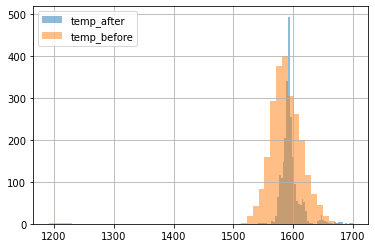

In [29]:
df_res['temp_after'].hist(bins=50, alpha=0.5)
df_res['temp_before'].hist(bins=50, alpha=0.5)
plt.legend(['temp_after', 'temp_before'])

Видно, что изначально температуры распределенны широко, а после подогрева и легирования значения более концетрированы

# 3 Вывод
Данные изучены, выделенны признаки для обучения

# 4 Выбор и обучение моделей

Выделим целевой и признаки обучения

In [30]:
features_train, features_valid, target_train, target_valid = train_test_split(
    df_res.drop(columns=['temp_after'], axis=1), df_res['temp_after'], test_size=0.2, random_state=42)

Пройдемся по разным моделям, а потом в конце выберем лучшую и используем метод grid search с кросс-валидацией

### LinearRegression

In [31]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print('mae:', mae(target_valid, predictions))

mae: 6.832871332997286


### RandomForestRegressor

In [32]:
%%time
model = RandomForestRegressor(max_depth=20, n_estimators=100, criterion='mae', random_state=16)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print('mae:', mae(target_valid, predictions))

mae: 5.939035269709547
Wall time: 25.6 s


### XGB

In [33]:
xg_reg = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    colsample_bytree = 0.7, 
    learning_rate = 0.6,
    max_depth = 100, 
    alpha = 20, 
    n_estimators = 100,
    booster = 'dart',
    subsample = 0.5,
    reg_lambda = .2,
)
xg_reg.fit(features_train,target_train)
predict = xg_reg.predict(features_valid)
print(mae(target_valid, predict))

7.81654934071901


### lgb

In [34]:
lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 5,
    'learning_rate': 0.6,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_bin':11,
    'max_depth':10,
    'verbose': 10
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5
)
y_pred = gbm.predict(features_valid, num_iteration=gbm.best_iteration)
print(mae(target_valid, y_pred))

[1]	valid_0's l1: 8.36748	valid_0's l2: 136.749
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 7.88223	valid_0's l2: 117.111
[3]	valid_0's l1: 7.30324	valid_0's l2: 99.6
[4]	valid_0's l1: 7.02685	valid_0's l2: 91.8171
[5]	valid_0's l1: 6.77492	valid_0's l2: 85.5722
[6]	valid_0's l1: 6.53636	valid_0's l2: 79.1434
[7]	valid_0's l1: 6.37897	valid_0's l2: 76.4086
[8]	valid_0's l1: 6.27303	valid_0's l2: 75.8337
[9]	valid_0's l1: 6.24408	valid_0's l2: 75.7202
[10]	valid_0's l1: 6.3086	valid_0's l2: 75.4965
[11]	valid_0's l1: 6.29875	valid_0's l2: 75.3641
[12]	valid_0's l1: 6.26388	valid_0's l2: 75.3924
[13]	valid_0's l1: 6.2022	valid_0's l2: 73.6679
[14]	valid_0's l1: 6.13384	valid_0's l2: 72.4436
[15]	valid_0's l1: 6.10677	valid_0's l2: 71.8233
[16]	valid_0's l1: 6.09934	valid_0's l2: 71.7446
[17]	valid_0's l1: 6.09344	valid_0's l2: 71.501
[18]	valid_0's l1: 6.10447	valid_0's l2: 71.3738
[19]	valid_0's l1: 5.99028	valid_0's l2: 69.3941
[20]	valid_0's l1: 5.952

### CatBoost

In [35]:
model = CatBoostRegressor(
    loss_function="RMSE", 
    iterations=105, 
    depth=4, 
    l2_leaf_reg=9,
    learning_rate=0.6, 
    random_seed=42,
    bagging_temperature=.1
)

model.fit(features_train, target_train, verbose=20)
predict = model.predict(features_valid)
print(mae(target_valid, predict))

0:	learn: 12.4141473	total: 55.9ms	remaining: 5.81s
20:	learn: 7.1420558	total: 77.9ms	remaining: 312ms
40:	learn: 6.2536507	total: 96.7ms	remaining: 151ms
60:	learn: 5.6441505	total: 116ms	remaining: 83.4ms
80:	learn: 5.2968314	total: 134ms	remaining: 39.8ms
100:	learn: 4.8189188	total: 156ms	remaining: 6.19ms
104:	learn: 4.7267564	total: 160ms	remaining: 0us
5.8104295205656005


### Выбираем модель КатБуст

*Примечание:* Модель лучше обучать по метрике RMSE. Предсказание будем делать на MAE

In [36]:
model = CatBoostRegressor(loss_function="RMSE", random_state=4, depth=3, l2_leaf_reg=.4)

grid = {
    'n_estimators': [1100, 1290, 1350],
    'learning_rate':[0.051, 0.0515]
}

grid_search_result = model.grid_search(grid, 
                                       X=df_res.drop('temp_after', axis=1), 
                                       y=df_res['temp_after'], 
                                       plot=True,
                                       cv=5,
                                       verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 8.805298946
bestIteration = 1020


bestTest = 8.697574639
bestIteration = 1065


bestTest = 8.781289454
bestIteration = 1285


bestTest = 8.69101306
bestIteration = 1163


bestTest = 8.777992297
bestIteration = 1318


bestTest = 8.69101306
bestIteration = 1163



In [37]:
print('Лучшие параметры')
grid_search_result['params']

Лучшие параметры


{'iterations': 1290, 'learning_rate': 0.0515}

In [38]:
model = CatBoostRegressor(
    loss_function="RMSE", 
    depth=3, 
    l2_leaf_reg=4,
    learning_rate=0.0515, 
    random_state=4,
    iterations=1290
)

model.fit(features_train, target_train, verbose=100)
predict = model.predict(features_valid)
print(mae(target_valid, predict))

0:	learn: 15.8849395	total: 2.8ms	remaining: 3.61s
100:	learn: 8.5882562	total: 82.5ms	remaining: 971ms
200:	learn: 7.5134947	total: 162ms	remaining: 877ms
300:	learn: 6.9257845	total: 247ms	remaining: 811ms
400:	learn: 6.5190294	total: 334ms	remaining: 740ms
500:	learn: 6.1998237	total: 428ms	remaining: 674ms
600:	learn: 5.9411596	total: 516ms	remaining: 592ms
700:	learn: 5.7236327	total: 605ms	remaining: 508ms
800:	learn: 5.5420483	total: 696ms	remaining: 425ms
900:	learn: 5.3782205	total: 787ms	remaining: 340ms
1000:	learn: 5.2039948	total: 877ms	remaining: 253ms
1100:	learn: 5.0640620	total: 971ms	remaining: 167ms
1200:	learn: 4.9236121	total: 1.05s	remaining: 78ms
1289:	learn: 4.8022815	total: 1.12s	remaining: 0us
5.203172047246478


### проверка на адекватность:
модель которая будет давать всегда среднее значение

In [39]:
def const_mean_model(features_valid):
    val = target_train.mean()
    return np.array([val for _ in range(len(features_valid))])

In [40]:
predict = const_mean_model(features_valid)
print(mae(target_valid, predict))

9.857126836379944


Наша модель адекватна, 5.2 < 9.8

# Вывод
Лучшая модель CatBost cо значением МАЕ: 5.2. Модель адекватна